Epoch 0, Loss: 0.14270788431167603
Epoch 500, Loss: 9.699519068817608e-06
Epoch 1000, Loss: 5.785638677480165e-06
Epoch 1500, Loss: 3.3809683372965083e-06
Epoch 2000, Loss: 1.9615508790593594e-06
Epoch 2500, Loss: 1.098719963010808e-06
Epoch 3000, Loss: 5.764407546848815e-07
Epoch 3500, Loss: 1.3729089687330998e-06
Epoch 4000, Loss: 1.5427437460857618e-07
Epoch 4500, Loss: 1.5284794585568307e-07


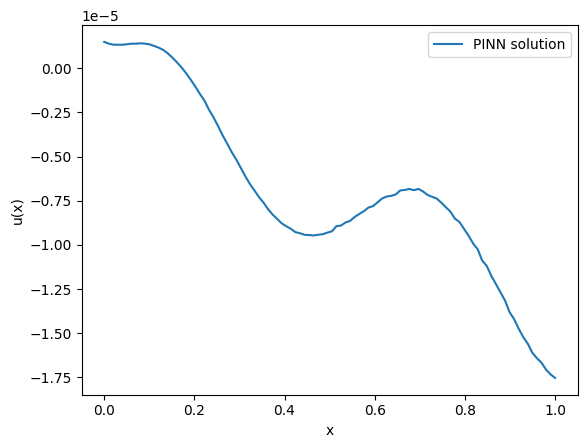

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network architecture
class PINN(tf.keras.Model):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = []
        for i in range(len(layers) - 2):
            self.hidden_layers.append(tf.keras.layers.Dense(layers[i+1], activation=tf.nn.tanh))
        self.out_layer = tf.keras.layers.Dense(layers[-1], activation=None)

    def call(self, x):
        z = x
        for layer in self.hidden_layers:
            z = layer(z)
        return self.out_layer(z)

# Define the residual function for the ODE: u''(x) + u(x) = 0
def compute_residual(model, x):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            u = model(x)
        u_x = tape1.gradient(u, x)
    u_xx = tape2.gradient(u_x, x)
    del tape1, tape2
    # Compute the residual: u_xx + u should be zero
    f = u_xx + u
    return f

# Loss function that combines the PDE residual loss with the boundary condition loss
def loss(model, x_collocation, x_boundary, u_boundary):
    # Compute residual at collocation points
    f = compute_residual(model, x_collocation)
    mse_f = tf.reduce_mean(tf.square(f))

    # Enforce boundary conditions
    u_pred_boundary = model(x_boundary)
    mse_b = tf.reduce_mean(tf.square(u_pred_boundary - u_boundary))

    return mse_f + mse_b

# Define the network architecture
layers = [1, 20, 20, 20, 1]  # Input layer, three hidden layers with 20 neurons each, and one output neuron
model = PINN(layers)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Create collocation points in the domain [0, 1]
x_collocation = tf.convert_to_tensor(np.linspace(0, 1, 100)[:, None], dtype=tf.float32)

# Boundary points and their corresponding values
x_boundary = tf.convert_to_tensor(np.array([[0.0], [1.0]]), dtype=tf.float32)
u_boundary = tf.convert_to_tensor(np.array([[0.0], [0.0]]), dtype=tf.float32)

# Training loop
epochs = 5000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x_collocation, x_boundary, u_boundary)
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {current_loss.numpy()}")

# Plot the resulting solution
x_plot = np.linspace(0, 1, 100)[:, None]
u_plot = model(tf.convert_to_tensor(x_plot, dtype=tf.float32))
plt.plot(x_plot, u_plot, label="PINN solution")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.show()
